<a href="https://colab.research.google.com/github/ccyyyYyzz/GI_GAN/blob/main/GI_GAN_4_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 GI dataset generation and data preprocessing

In [20]:
import tensorflow as tf

# GPU配置
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np
from sklearn.datasets import load_digits
from skimage.transform import resize

# 设置随机种子
np.random.seed(42)
tf.random.set_seed(42)

def prepare_data(num_images=5000, image_size=32):
    """从MNIST数据集加载并预处理手写数字图像"""
    digits = load_digits()
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)
    images = np.array(images, dtype=np.float32)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    return images

def generate_speckle_patterns(num_patterns, image_size):
    """生成随机光斑模式"""
    return np.random.rand(num_patterns, image_size, image_size)

def calculate_bucket_signal(image, speckle_patterns):
    """计算bucket信号"""
    return np.sum(image * speckle_patterns, axis=(1, 2))

def gi_reconstruction(bucket_signal, speckle_patterns):
    """传统鬼影成像重构"""
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)

    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle

    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

def generate_initial_reconstructions(images, noise_level=0.3):
    """使用传统鬼影成像方法生成带有噪声的初步重构图像"""
    # 处理输入维度
    if images.ndim == 2:
        images = np.expand_dims(np.expand_dims(images, 0), -1)
    elif images.ndim == 3:
        if images.shape[2] <= 4:
            images = np.expand_dims(images, 0)
        else:
            images = np.expand_dims(images, -1)

    num_images, height, width, channels = images.shape

    # 计算测量次数和beta值
    num_measurements = int(1000 * (1 - noise_level))
    beta = num_measurements / (height * width)

    reconstructions = np.zeros_like(images)

    for i in range(num_images):
        image = images[i, ..., 0]  # 取单通道

        # 生成光斑模式
        speckle_patterns = generate_speckle_patterns(num_measurements, height)

        # 计算bucket信号
        bucket_signal = calculate_bucket_signal(image, speckle_patterns)

        # 进行GI重构
        reconstruction = gi_reconstruction(bucket_signal, speckle_patterns)

        # 归一化
        reconstruction = (reconstruction - np.min(reconstruction)) / (np.max(reconstruction) - np.min(reconstruction))

        reconstructions[i, ..., 0] = reconstruction

    # 添加噪声
    noise = np.random.normal(0, noise_level/2, reconstructions.shape)
    reconstructions = np.clip(reconstructions + noise, 0, 1)

    # 恢复原始维度
    if images.shape[1] == 2:
        reconstructions = np.squeeze(reconstructions)
    elif images.shape[1] == 3:
        if channels == 1:
            reconstructions = np.squeeze(reconstructions, axis=-1)

    return reconstructions

    # 准备数据
images = prepare_data(num_images=5000)
    # 生成重构图像
initial_reconstructions = generate_initial_reconstructions(images)


GAN model training

In [24]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)


# 修改生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')
    ])
    return model

# 修改判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# 定义评估指标
class EvaluationMetrics:
    @staticmethod
    def calculate_psnr(original, generated):
        return psnr(original, generated, data_range=1.0)

    @staticmethod
    def calculate_ssim(original, generated):
        return ssim(original, generated, data_range=1.0)

    @staticmethod
    def calculate_mse(original, generated):
        return mean_squared_error(original.flatten(), generated.flatten())

    @staticmethod
    def evaluate_batch(original_batch, generated_batch):
        batch_psnr = []
        batch_ssim = []
        batch_mse = []

        for orig, gen in zip(original_batch, generated_batch):
            if orig.ndim == 3:
                orig = orig.squeeze()
            if gen.ndim == 3:
                gen = gen.squeeze()

            batch_psnr.append(EvaluationMetrics.calculate_psnr(orig, gen))
            batch_ssim.append(EvaluationMetrics.calculate_ssim(orig, gen))
            batch_mse.append(EvaluationMetrics.calculate_mse(orig, gen))

        return {
            'psnr': np.mean(batch_psnr),
            'ssim': np.mean(batch_ssim),
            'mse': np.mean(batch_mse)
        }

class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.metrics_tracker = {
            'psnr': [], 'ssim': [], 'mse': [],
            'g_loss': [], 'd_loss': []
        }

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn


    @tf.function
    def train_step(self, data):
        real_images, initial_reconstructions = data
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=tf.shape(real_images), mean=0.0, stddev=0.12)

        # 添加噪声到真实和生成的图像
        noisy_real = real_images + noise
        fake_images = self.generator(initial_reconstructions, training=True)
        noisy_fake = fake_images + noise

        # 确保输入数据类型为 float32
        noisy_real = tf.cast(noisy_real, tf.float32)
        initial_reconstructions = tf.cast(initial_reconstructions, tf.float32)

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(noisy_real, training=True)
            fake_output = self.discriminator(noisy_fake, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = real_loss + fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # 计算评估指标
        psnr = tf.image.psnr(real_images, fake_images, max_val=1.0)
        ssim = tf.image.ssim(real_images, fake_images, max_val=1.0)
        mse = tf.reduce_mean(tf.square(real_images - fake_images))

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "psnr": tf.reduce_mean(psnr),
            "ssim": tf.reduce_mean(ssim),
            "mse": mse
        }
# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    plt.figure(figsize=(15, 9))
    for i in range(n):
        # Original images
        plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Initial reconstructions
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Initial')

        # Generated images
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Generated')

    plt.tight_layout()
    plt.savefig(f'GAM_results_epoch_{epoch}.png')
    plt.close()

# 绘制评估指标
def plot_metrics(metrics_tracker):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].plot(metrics_tracker['g_loss'], label='Generator Loss')
    axes[0, 0].plot(metrics_tracker['d_loss'], label='Discriminator Loss')
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].legend()

    axes[0, 1].plot(metrics_tracker['psnr'])
    axes[0, 1].set_title('PSNR')

    axes[1, 0].plot(metrics_tracker['ssim'])
    axes[1, 0].set_title('SSIM')

    axes[1, 1].plot(metrics_tracker['mse'])
    axes[1, 1].set_title('MSE')

    plt.tight_layout()
    plt.savefig('gan_metrics.png')
    plt.close()

# 训练GAN
def train_gan(gan, dataset, epochs=20, batch_size=32):

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        epoch_metrics = {
            'g_loss': [], 'd_loss': [],
            'psnr': [], 'ssim': [], 'mse': []
        }

        for batch in dataset.batch(batch_size):
            metrics = gan.train_step(batch)

            for key in epoch_metrics.keys():
                epoch_metrics[key].append(metrics[key].numpy())

        # 计算每个epoch的平均值
        epoch_averages = {
            key: np.mean(values) for key, values in epoch_metrics.items()
        }

        # 存储指标
        for key, value in epoch_averages.items():
            gan.metrics_tracker[key].append(value)

        print(f"G Loss: {epoch_averages['g_loss']:.4f}, "
              f"D Loss: {epoch_averages['d_loss']:.4f}, "
              f"PSNR: {epoch_averages['psnr']:.2f}, "
              f"SSIM: {epoch_averages['ssim']:.4f}, "
              f"MSE: {epoch_averages['mse']:.6f}")

        if (epoch + 1) % 10 == 0:  # 每10个epoch显示一次结果
            display_results(gan, dataset, epoch + 1)

    # 绘制最终指标
    plot_metrics(gan.metrics_tracker)

# 主函数
def main():

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((
        images[..., np.newaxis],
        initial_reconstructions[..., np.newaxis]
    ))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()

    # 创建并编译GAN
    gan = GAN(generator, discriminator)
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.1),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.00011, beta_1=0.1),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=80, batch_size=32)

if __name__ == "__main__":
    main()



Epoch 1/80
G Loss: 1.0785, D Loss: 0.9407, PSNR: 7.14, SSIM: 0.2478, MSE: 0.241428
Epoch 2/80
G Loss: 1.8272, D Loss: 0.3249, PSNR: 12.33, SSIM: 0.5233, MSE: 0.062045
Epoch 3/80
G Loss: 3.4192, D Loss: 0.0596, PSNR: 12.39, SSIM: 0.5489, MSE: 0.062702
Epoch 4/80
G Loss: 4.5547, D Loss: 0.0205, PSNR: 12.00, SSIM: 0.5402, MSE: 0.069130
Epoch 5/80
G Loss: 5.3567, D Loss: 0.0097, PSNR: 11.63, SSIM: 0.5272, MSE: 0.075553
Epoch 6/80
G Loss: 5.9625, D Loss: 0.0056, PSNR: 11.32, SSIM: 0.5165, MSE: 0.080929
Epoch 7/80
G Loss: 6.4787, D Loss: 0.0035, PSNR: 11.10, SSIM: 0.5085, MSE: 0.085007
Epoch 8/80
G Loss: 6.8457, D Loss: 0.0024, PSNR: 10.98, SSIM: 0.5034, MSE: 0.087144
Epoch 9/80
G Loss: 2.0952, D Loss: 0.6895, PSNR: 11.79, SSIM: 0.4749, MSE: 0.071307
Epoch 10/80
G Loss: 1.6339, D Loss: 0.3360, PSNR: 13.15, SSIM: 0.5199, MSE: 0.052927
Epoch 11/80
G Loss: 0.2778, D Loss: 0.7760, PSNR: 14.32, SSIM: 0.5350, MSE: 0.042123
Epoch 12/80
G Loss: 0.1113, D Loss: 0.9708, PSNR: 14.61, SSIM: 0.5529, MSE:

Image reading

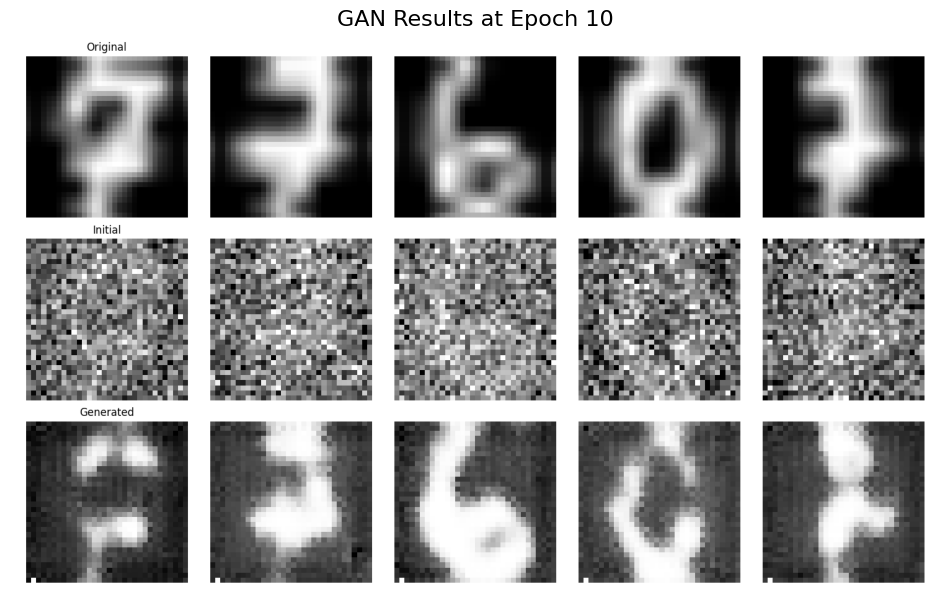

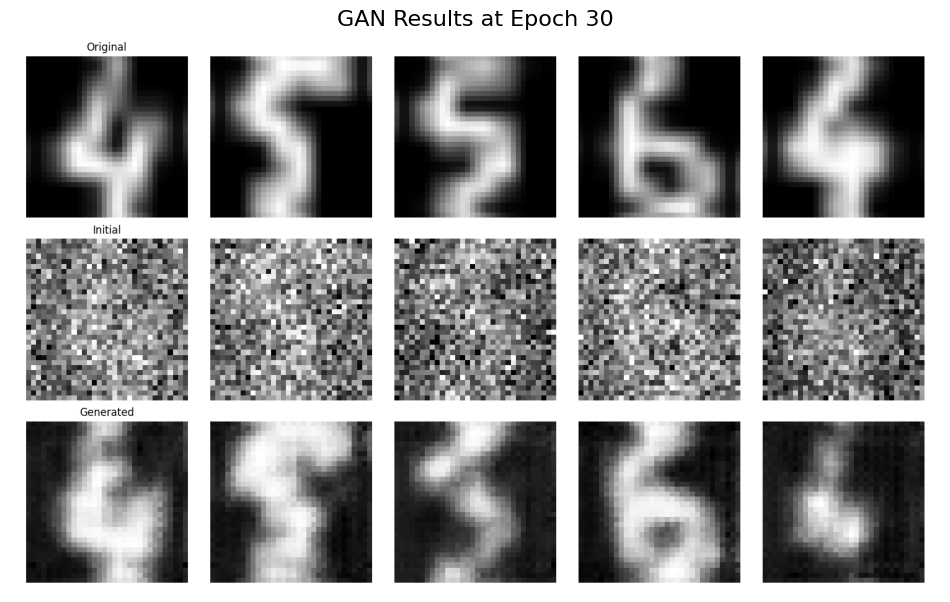

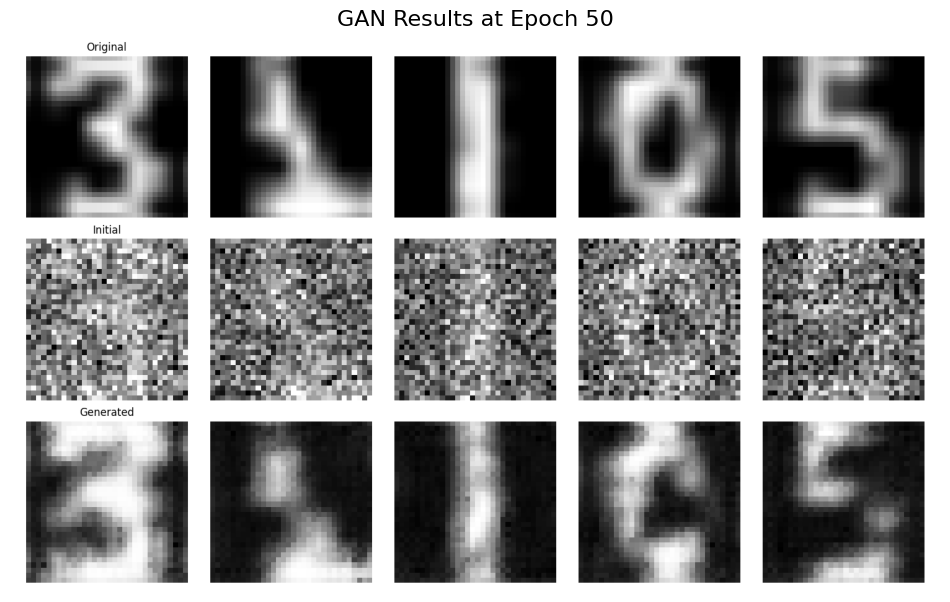

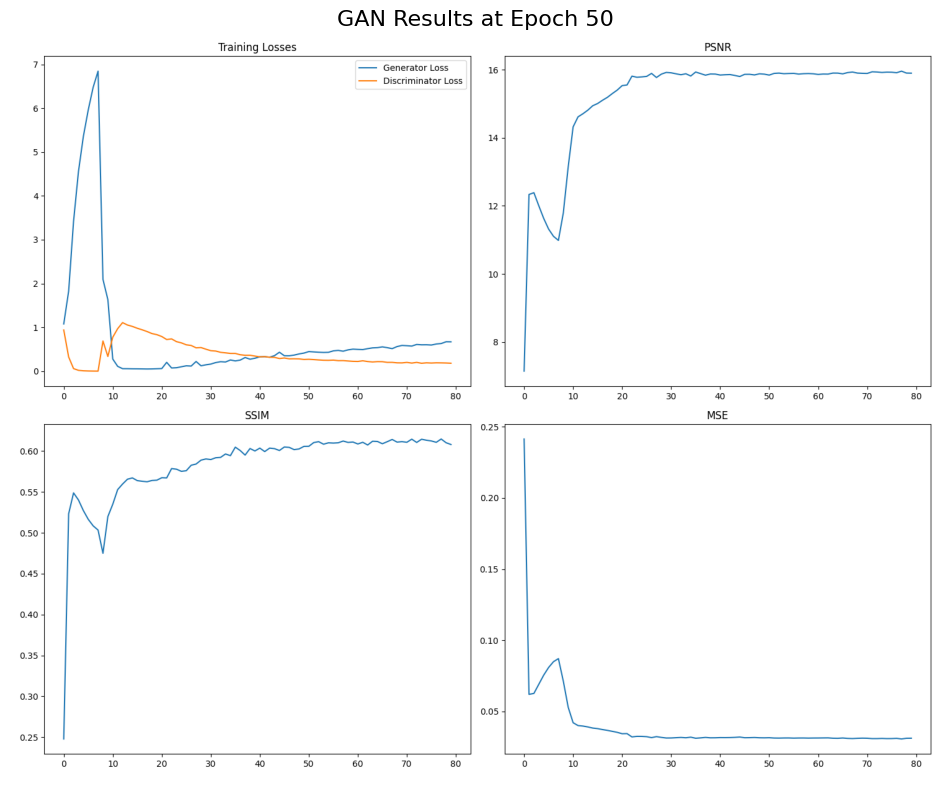

In [25]:
# 读取图像
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_path = '/content/GAM_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAM_results_epoch_30.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 30', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAM_results_epoch_50.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()

image_path = '/content/gan_metrics.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()